In [53]:
import argparse
import logging
import os
from mypredictor import Predictor
from metric import Metric
import csv
import json
import pickle
from preprocess import Embedding, CSDataset
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
model_dir = "..\model\pad100"
epoch = 17
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s')

model_path = os.path.join(model_dir, "model.pkl.{}".format(epoch))
config_path = os.path.join(model_dir, "config.json")

logging.info('Loading configuration file from {}'.format(config_path))
with open(config_path) as f:
    config = json.load(f)

embedding_pkl_path = os.path.join(model_dir, config["embedding_pkl_path"])
val_pkl_path = os.path.join(model_dir, config["val_pkl_path"])
labelEncoder_path = os.path.join(model_dir, config["labelEncoder_path"])
with open(embedding_pkl_path, "rb") as f:
    config["model_parameters"]["embedding"] = pickle.load(f).vectors
    logging.info( "Load embedding from {}".format(embedding_pkl_path))
with open(val_pkl_path, "rb") as f:
    config["model_parameters"]["valid"] = pickle.load(f)
    logging.info( "Load val from {}".format(val_pkl_path))
with open(labelEncoder_path, "rb") as f:
    config["model_parameters"]["labelEncoder"] = pickle.load(f)
    logging.info( "Load labelEncoder from {}".format(labelEncoder_path))

le = config["model_parameters"]["labelEncoder"]
num_classes = len(le.classes_)
class_list = list(le.classes_)

print(class_list)

predictor = Predictor(metric=Metric(), **config["model_parameters"])
predictor.load(model_path)


logging.info("Loading testing data.")
#with open(args.test_data_path, "rb") as f:
#    pass
valid = config["model_parameters"]["valid"] # CSDataset
test = valid


logging.info("Predicting...")
predicts, solution = predictor.predict_dataset(test, test.collate_fn)


2019-07-24 10:25:48,243 - <ipython-input-27-f6b254f596f3>[line:8] - INFO: Loading configuration file from ..\model\pad100\config.json
2019-07-24 10:26:02,848 - <ipython-input-27-f6b254f596f3>[line:17] - INFO: Load embedding from ..\model\pad100\embedding.pkl
2019-07-24 10:26:02,855 - <ipython-input-27-f6b254f596f3>[line:20] - INFO: Load val from ..\model\pad100\val.pkl
2019-07-24 10:26:02,858 - <ipython-input-27-f6b254f596f3>[line:23] - INFO: Load labelEncoder from ..\model\pad100\labelEncoder.pkl


['Does the program support certain features?', 'Download/installation issues with Application Manager.', 'Error message pops up when I perform some action.', 'How to activate/register my product?', 'How to capture?', 'How to create disc?', 'How to edit?', 'How to produce file?', 'How to set preferences/settings?', 'How to share/upload video?', 'How to use certain effects/features?', 'I am having problems using CyberLink Cloud via my CyberLink software.', 'I am having trouble signing in to my CyberLink software.', 'I have a suggestion.', 'I have activation/registration problem.', 'I have component activation problem', 'I have install/uninstall/upgrade/patch problems.', 'I have other product feature question.', 'I have other questions.', 'I have other questions/issues.', 'I have other trouble(s).', 'I have problem creating disc.', 'I have problem launching the program.', 'I have problem producing file.', 'I have problem sharing/uploading video.', 'I have problem using certain features/ef

2019-07-24 10:26:02,870 - mypredictor.py[line:32] - INFO: Embedding size: (1551018,300)
2019-07-24 10:26:06,775 - mypredictor.py[line:40] - INFO: Learning_rate: 0.01
2019-07-24 10:26:06,776 - mypredictor.py[line:43] - INFO: Loss: BCEWithLogitsLoss()
2019-07-24 10:26:06,915 - <ipython-input-27-f6b254f596f3>[line:35] - INFO: Loading testing data.
2019-07-24 10:26:06,917 - <ipython-input-27-f6b254f596f3>[line:42] - INFO: Predicting...
predicting:   0%|                              | 0/22 [00:00<?, ?it/s]

torch.Size([32, 100, 128]) torch.Size([1, 32, 128])


predicting: 100%|█████████████████████| 22/22 [00:02<00:00,  9.83it/s]


In [133]:
def analysis(predicts, gt, labels):
    matrix = confusion_matrix(gt, predicts, labels=labels)
    df = pd.DataFrame(matrix, columns=labels, index=labels)
    #print(df.head())
    
    plt.figure(figsize=(20, 15))
    plt.title('Confusion Matrix', y=1.03, fontsize = 25)

    cmap = sn.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    heatmap = sn.heatmap(df, annot=True, annot_kws={"size": 16}, cmap=cmap)
    plt.ylabel('Ground Truth', fontsize = 20)
    plt.xlabel('Prediction', fontsize = 20)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment="right")
    plt.savefig('ConfusionMatrix.jpg')

    n = 0
    n_correct = 0
    '''
    for i in range(len(gt)):
        n += 1
        if gt[i][maxindex[i]] == 1:
            n_correct += 1
    print("Accuracy: {}".format(n_correct / n))
    print(len(matrix), len(matrix[0]))
    '''

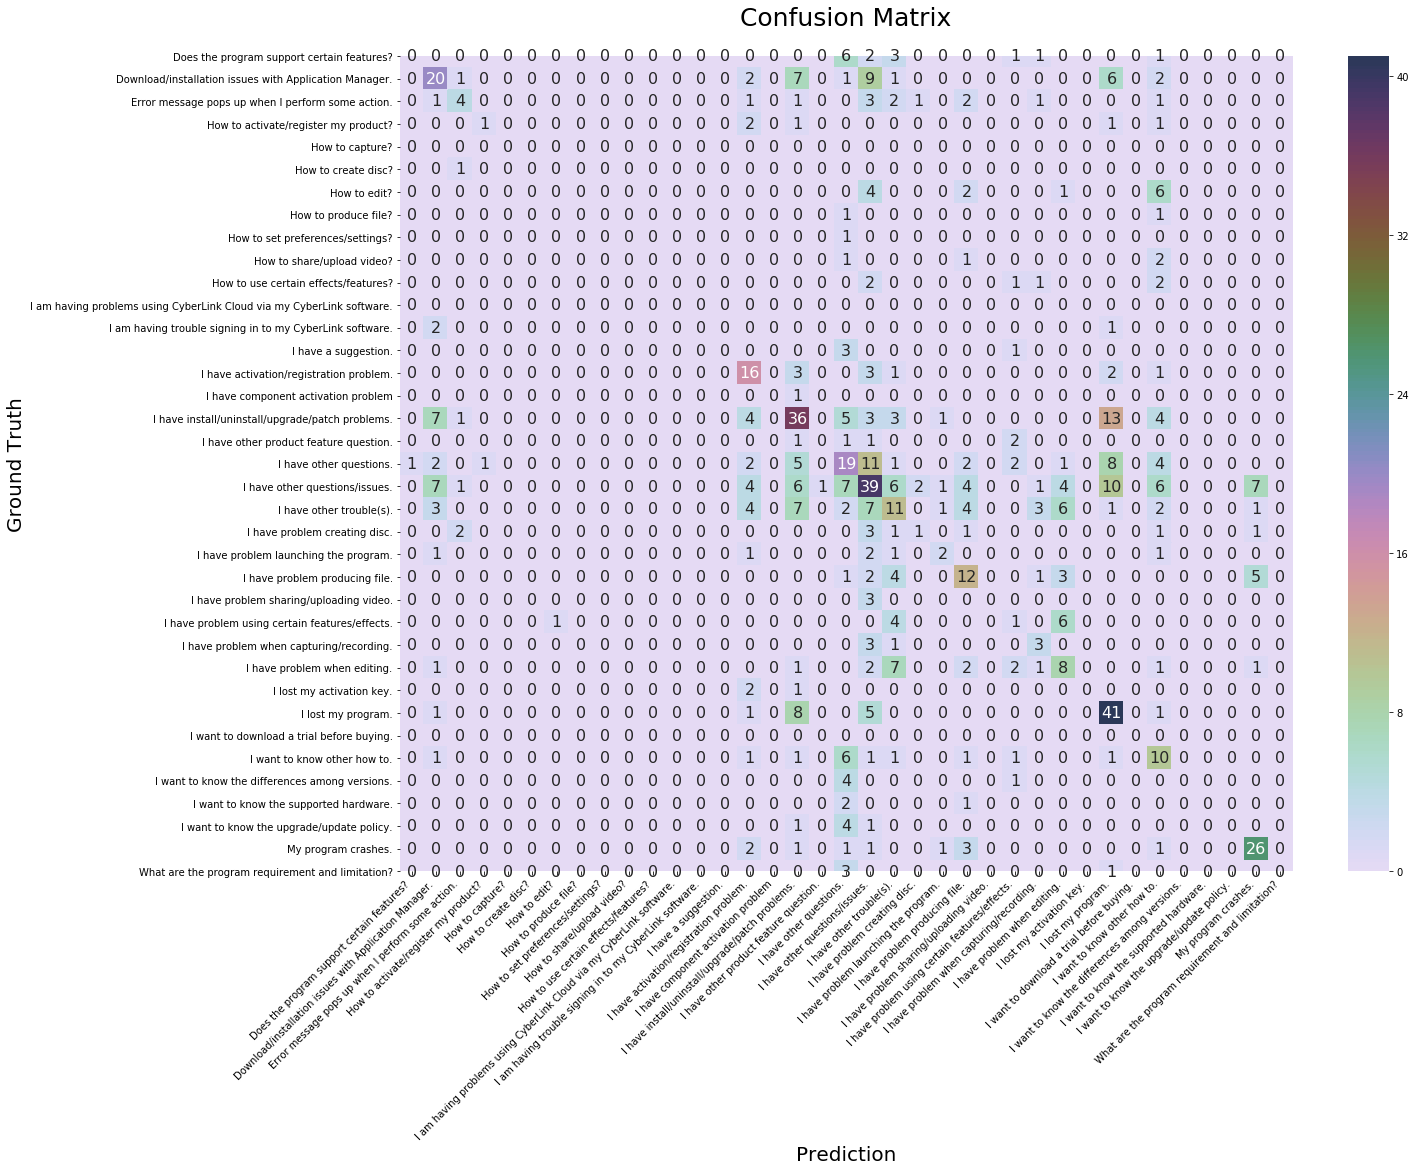

In [134]:
predicts_index = torch.argmax(predicts, dim=1)
gt_index = torch.argmax(solution, dim=1)
predicts_str = list(le.inverse_transform(predicts_index))
gt_str = list(le.inverse_transform(gt_index))
    
analysis(predicts_str, gt_str, labels=class_list)